In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [46]:
df = pd.read_csv('../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [47]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [48]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [49]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [50]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [51]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])   # Sequence of `seq_length`
        targets.append(data[i+seq_length])       # Next value as target
    
    return np.array(sequences), np.array(targets)

In [52]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[0:int(n*0.6)]
val_df1 = first_piece[int(n*0.8):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1) # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1)  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1)  # (batch, output_dim)


In [53]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2) # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2)  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2)  # (batch, output_dim)

In [54]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 = third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3)  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3) # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3)  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3)  # (batch, output_dim)

In [55]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 = fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4)  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4) # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4)  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4)  # (batch, output_dim)

In [56]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 200
num_layers = 2
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cpu")  # Use "cuda" if you have a GPU

model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cpu")  # Use "cuda" if you have a GPU

model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to("cpu")  # Use "cuda" if you have a GPU

criterion1 = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)
criterion3 = nn.MSELoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.01)

In [57]:
# Train model 1
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    y_pred = model1(train_seq_tensor1)
    
    loss = criterion1(y_pred, train_label_tensor1)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())

    # Validation
    model1.eval()
    with torch.no_grad():
        y_val = model1(val_seq_tensor1)
        val_loss = criterion1(y_val, val_label_tensor1)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.9281087517738342, Val Loss: 6.105515480041504
Epoch 10, Train Loss: 0.32172274589538574, Val Loss: 3.438333511352539
Epoch 20, Train Loss: 0.04788873717188835, Val Loss: 1.6746797561645508
Epoch 30, Train Loss: 0.02413506619632244, Val Loss: 1.0210341215133667
Epoch 40, Train Loss: 0.013730622828006744, Val Loss: 0.5774745345115662
Epoch 50, Train Loss: 0.010770720429718494, Val Loss: 0.16254284977912903
Epoch 60, Train Loss: 0.008986664935946465, Val Loss: 0.20686772465705872
Epoch 70, Train Loss: 0.007548361551016569, Val Loss: 0.23827531933784485
Epoch 80, Train Loss: 0.006540515460073948, Val Loss: 0.4045206308364868
Epoch 90, Train Loss: 0.006214239168912172, Val Loss: 0.49667516350746155


In [58]:
# Train model 2
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer2.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion2(y_pred, train_label_tensor2)
    loss.backward()
    optimizer2.step()
    
    train_losses.append(loss.item())

    # Validation
    model2.eval()
    with torch.no_grad():
        y_val = model2(val_seq_tensor2)
        val_loss = criterion1(y_val, val_label_tensor2)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 1.0504838228225708, Val Loss: 3.5560574531555176
Epoch 10, Train Loss: 0.2804352939128876, Val Loss: 0.5619409680366516
Epoch 20, Train Loss: 0.06411877274513245, Val Loss: 0.08855165541172028
Epoch 30, Train Loss: 0.02938077785074711, Val Loss: 0.011801638640463352
Epoch 40, Train Loss: 0.02121119387447834, Val Loss: 0.010100994259119034
Epoch 50, Train Loss: 0.018322937190532684, Val Loss: 0.02977922186255455
Epoch 60, Train Loss: 0.01637287810444832, Val Loss: 0.020517896860837936
Epoch 70, Train Loss: 0.014855562709271908, Val Loss: 0.03798368573188782
Epoch 80, Train Loss: 0.013586543500423431, Val Loss: 0.03787115588784218
Epoch 90, Train Loss: 0.012570175342261791, Val Loss: 0.03909597173333168


In [59]:
# Train model 3
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model3.train()
    
    optimizer3.zero_grad()
    y_pred = model3(train_seq_tensor3)
    
    loss = criterion3(y_pred, train_label_tensor3)
    loss.backward()
    optimizer3.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion3(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.9436404705047607, Val Loss: 1.3863636255264282
Epoch 10, Train Loss: 0.5146144032478333, Val Loss: 0.36259108781814575
Epoch 20, Train Loss: 0.14535297453403473, Val Loss: 0.11061383038759232
Epoch 30, Train Loss: 0.0542905330657959, Val Loss: 0.014496270567178726
Epoch 40, Train Loss: 0.06818386912345886, Val Loss: 0.053068071603775024
Epoch 50, Train Loss: 0.032328907400369644, Val Loss: 0.01864791288971901
Epoch 60, Train Loss: 0.02405317686498165, Val Loss: 0.017202109098434448
Epoch 70, Train Loss: 0.019024578854441643, Val Loss: 0.01661120541393757
Epoch 80, Train Loss: 0.016883067786693573, Val Loss: 0.018311375752091408
Epoch 90, Train Loss: 0.015018671751022339, Val Loss: 0.016692491248250008


In [60]:
import copy
# Average the models
average_model = copy.deepcopy(model1)
models = [model1, model2, model3]
# Compute the average of the parameters
with torch.no_grad():
    for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
        avg_param = sum(params) / len(models)  # Element-wise average
        params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# The `average_model` now has the averaged parameters

In [61]:
# Normalize the data (each partition separately)
test_mean4 = (train_mean1 + train_mean2 + train_mean3 + train_mean4)/4
test_std = (train_std1 + train_std2 + train_std3 + train_std4)/4
test_df = fourth_piece
test_df = (test_df - test_mean4)/test_std

In [62]:
test_seq4, test_labels4 = create_sequences(test_df.values, 12)
test_tensor_seq4 = torch.FloatTensor(test_seq4)
test_tensor_labels4 = torch.FloatTensor(test_labels4)

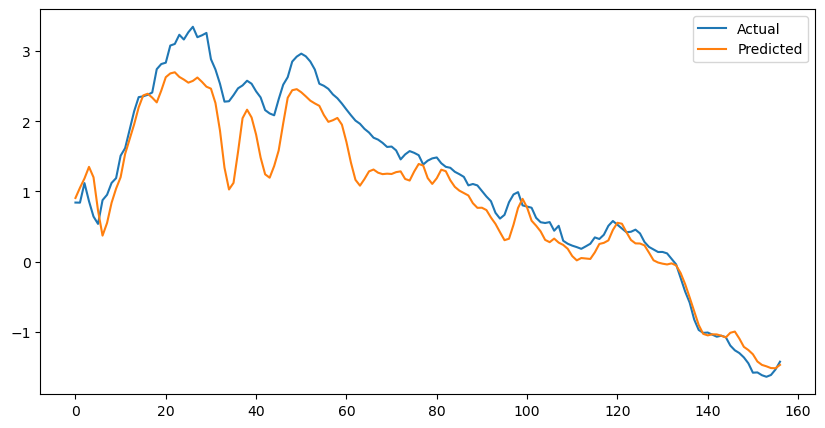

In [63]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_tensor_seq4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.savefig('model123_avg_fl')

In [64]:
mae = criterion3(y_pred_test, test_tensor_labels4)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_tensor_labels4)}')

Mean Absolute Error: 0.16091182827949524
MARE: 0.2707061469554901


In [65]:
window = test_tensor_seq4.clone()[0]
average_model(window.unsqueeze(0))

tensor([[0.9066]], grad_fn=<AddmmBackward0>)

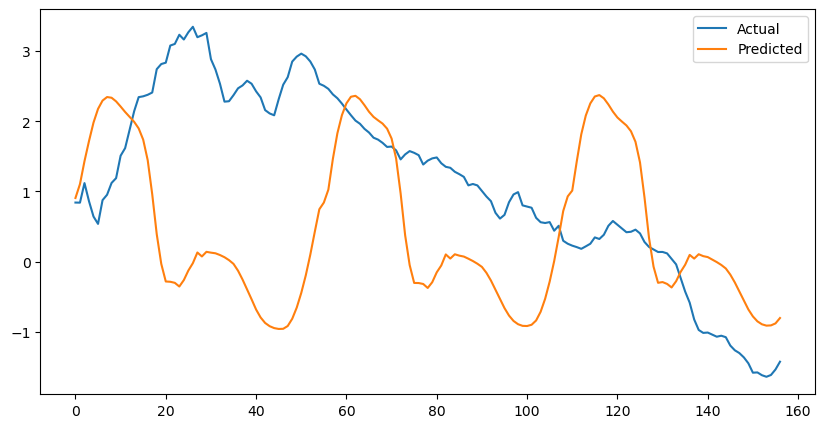

In [66]:
# Sequence prediction
average_model.eval()
N_steps = 157
window = test_tensor_seq4.clone()[0]
predictions = []
with torch.no_grad():
    for _ in range(N_steps):
        next_step_pred = average_model(window.unsqueeze(0))
        # shift window by one
        window = window[1:, :]
        # append prediction
        window = torch.cat((window, next_step_pred))
        # print(next_step_pred.shape)
        predictions.append(next_step_pred.squeeze(0))
    
# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4.numpy()[:N_steps], label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.savefig('small_seq_model123_avg_fl')        
